In [1]:
from telegram.ext.updater import Updater
from telegram.update import Update
from telegram.ext.callbackcontext import CallbackContext
from telegram.ext.commandhandler import CommandHandler
from telegram.ext.messagehandler import MessageHandler
from telegram.ext.filters import Filters
import plotly.express as px

from io import BytesIO
from keras_preprocessing import image
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pickle
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm
import cv2 as cv

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set working Dir
path = "D:\Python\Image-Recommendation"
os.chdir(path)
os.getcwd()

'D:\\Python\\Image-Recommendation'

In [3]:
updater = Updater("5887773720:AAHWQMLHOdXyQRcQdYK2L5gB62BXOdXP1pU",use_context=True)

In [4]:
data = pd.read_csv('save-dataset/product_data.csv')
feature_list = np.array(pickle.load(open('save-dataset/embeddings.pkl','rb')))
filenames = pickle.load(open('save-dataset/filenames.pkl','rb'))

In [5]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=6,algorithm='brute',metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

In [7]:
def load_img(img):
    img = image.load_img(img, target_size=(512, 512))
    fig = px.imshow(img)
    fig.update_layout(width=400, height=400, margin=dict(l=10, r=10, b=10, t=10))
    fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
    fig.show()   
  
def start(update: Update, context: CallbackContext):
    user = update.message.from_user
    print("Name of user :",user.first_name)
    update.message.reply_text(
        "Welcome to the image based product recommendation app. Please upload product image to find similar product.")

In [8]:
from rembg import remove
import cv2

def remove_background(input_path):    
    output_path = str(os.path.splitext(input_path)[0]) + '_white.jpg'    

    input = cv2.imread(input_path)
    output = remove(input)
    cv2.imwrite(output_path, output)    
    
    return output_path

In [9]:
# Function to Remove Prefix
def remove_prefix(text, prefix):
    if prefix and text.startswith(prefix):
        return text[len(prefix):]
    return text

def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

def image_recommendation(update,image_path,num=5): 
      
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")    
    load_img(image_path)
    
    test_img_norm_img = extract_features(image_path,model)
    distances,indices = neighbors.kneighbors([test_img_norm_img]) 
    
    print("\n")
    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------")  
    
    for i,file in enumerate(indices[0][1:num+1]):
        rec_id = int(remove_prefix(os.path.splitext(filenames[file])[0],'Data\Images\Image_'))
        product_id = data.loc[data['product_id'] == rec_id]['asin'].tolist()[0].split(' - ')[0]        
        title = data.loc[data['product_id'] == rec_id]['title'].tolist()[0].split(' - ')[0]
        brand = data.loc[data['product_id'] == rec_id]['brand'].tolist()[0].split(' - ')[0]
        cost = '$'+str(data.loc[data['product_id'] == rec_id]['price'].tolist()[0])
        rating = str(float(data.loc[data['product_id'] == rec_id]['rating'].tolist()[0])) + ' out of 5.0'
        url = "https://www.amazon.com/dp/"+ str(product_id)
        
        r_product = '\n'.join(['Product: '+  str(i+1) ,
                               'Product ID: '+ str(product_id),
                               'Title: '+ str(title),
                               'Brand: '+ str(brand),
                               'Price: ' + str(cost),
                               'Rating: '+ rating,
                               'Url: ' + url
                              ])
        
        print(r_product)        
        load_img(filenames[file])         
        update.message.reply_photo(photo=open(filenames[file], 'rb'),caption=r_product)  
        


In [10]:
def photo(update: Update, context: CallbackContext):
    user = update.message.from_user
    print("Name of user ",user.first_name)
    photo_file = update.message.photo[-1].get_file()
    photo_file.download(r'telegram-bot\user_'+ user.first_name+'.jpg')
    image_path = r'telegram-bot\user_'+ user.first_name+'.jpg'
    new_image_path = remove_background(image_path)
    if os.path.isfile(new_image_path):
        image_path = new_image_path    
    image_recommendation(update,image_path,5)       

In [11]:
def unknown(update: Update, context: CallbackContext):
    msg = update.message.text
    user = update.message.from_user
    if(msg.lower() == 'hi' or msg.lower() == 'hello'):
        update.message.reply_text(
        "Welcome to the image based product recommendation app. Please upload product image to find similar product.")
    else:
        update.message.reply_text(
        "Sorry "+user.first_name+ "! We are unable to understand you. Please upload product image to find similar product.")

fig = plt.figure(figsize=(18, 18))
def printImg(update: Update, context: CallbackContext):    
    update.message.reply_text("Input Image:")
    file = context.bot.get_file(update.message.photo[-1].file_id)
    f = BytesIO(file.download_as_bytearray)
    file_bytes = np.asarray(bytearray(f.read(), dtype=np.uint8))
    print(file_bytes)   

<Figure size 1800x1800 with 0 Axes>

In [12]:
updater.dispatcher.add_handler(CommandHandler('start', start))
updater.dispatcher.add_handler(MessageHandler(Filters.text, unknown))
updater.dispatcher.add_handler(MessageHandler(Filters.command, unknown))
updater.dispatcher.add_handler(MessageHandler(Filters.photo,photo))

Name of user : shashank
Name of user  shashank
-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------



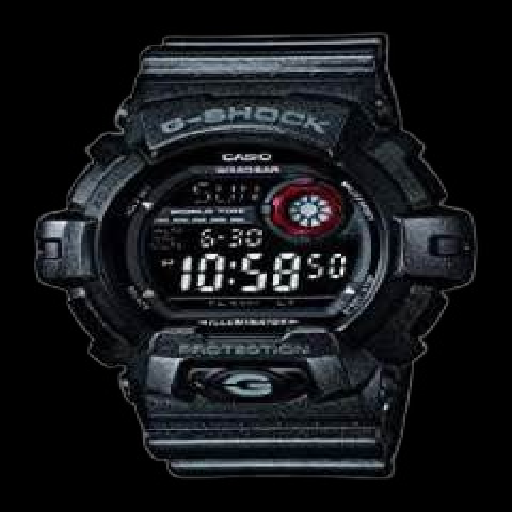

1/1 [==============================] - 5s 5s/step


-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------
Product: 1
Product ID: B00BF2CUYG
Title: Casio G-Shock Garish Color Super Illuminator
Brand: Casio
Price: $61.61
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B00BF2CUYG



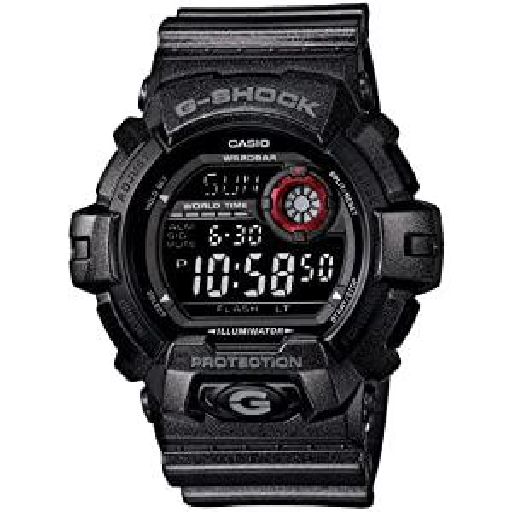

Product: 2
Product ID: B00791YX10
Title: Casio Men's G6900KG-3CR G-Shock Military Green Multi-Function Digital Watch
Brand: Casio
Price: $93.0
Rating: 4.0 out of 5.0
Url: https://www.amazon.com/dp/B00791YX10



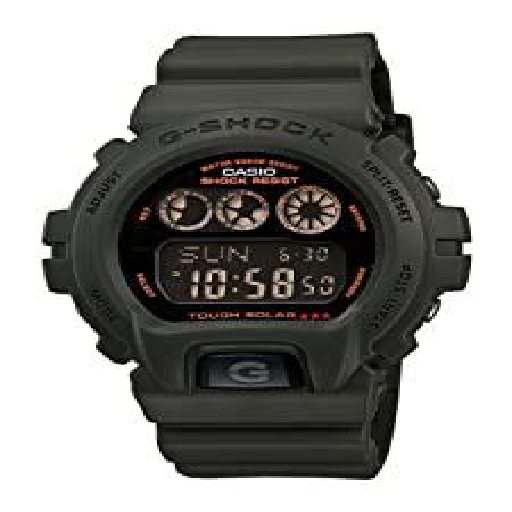

Product: 3
Product ID: B00BU6RUU6
Title: Casio Men's GD350-1B G Shock Black Watch
Brand: Casio
Price: $112.0
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B00BU6RUU6



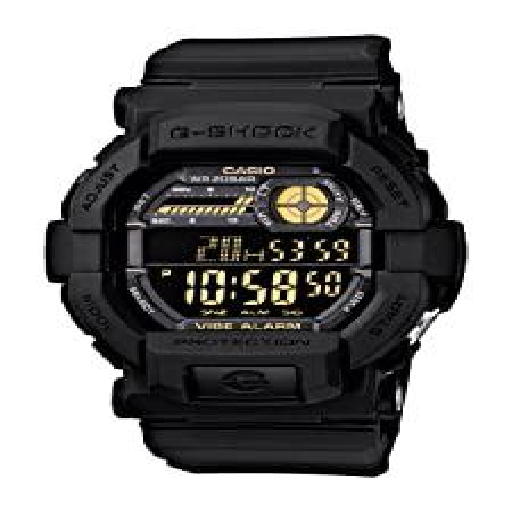

Product: 4
Product ID: B000AR7RZY
Title: Casio Men's W94HF-3AV Sport Watch
Brand: Casio
Price: $17.47
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B000AR7RZY



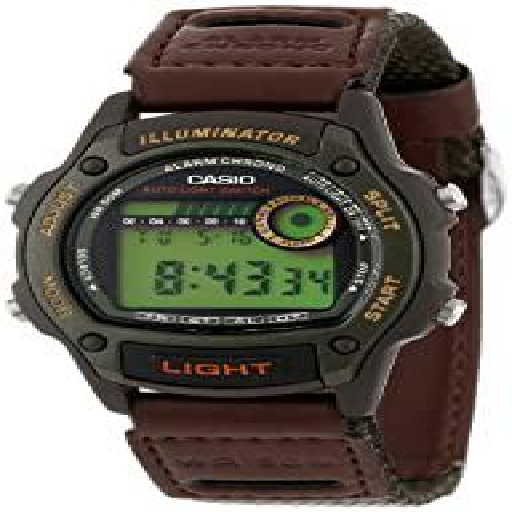

Product: 5
Product ID: B006WV32Z6
Title: Casio G-Shock Mens Watch G8900A-4D
Brand: Casio
Price: $93.0
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B006WV32Z6



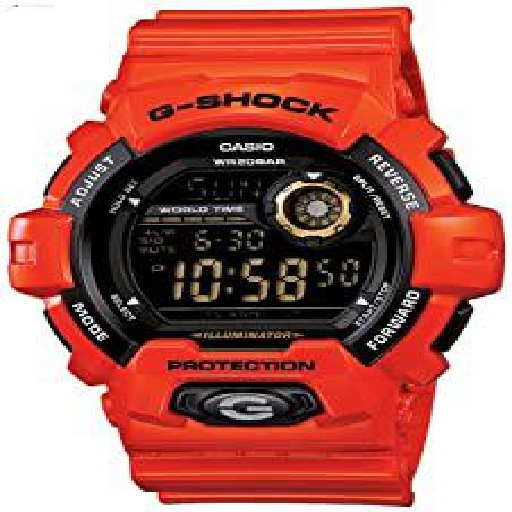

Name of user : shashank
Name of user  shashank
-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------



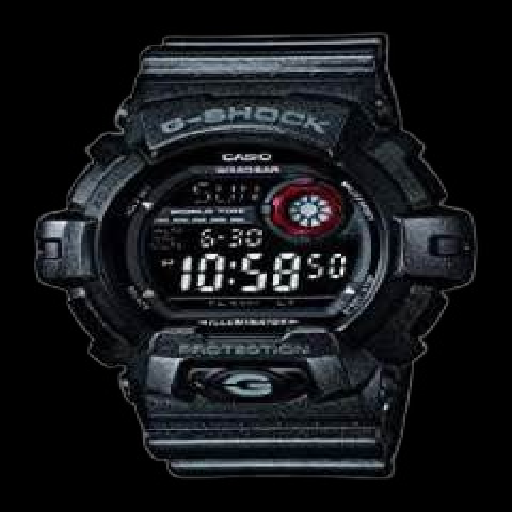

1/1 [==============================] - 0s 409ms/step


-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------
Product: 1
Product ID: B00BF2CUYG
Title: Casio G-Shock Garish Color Super Illuminator
Brand: Casio
Price: $61.61
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B00BF2CUYG



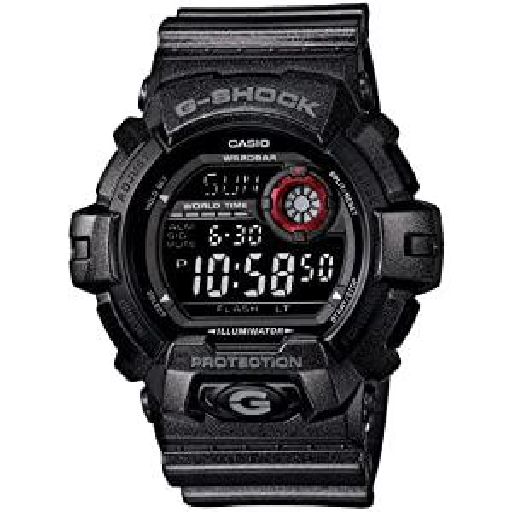

Product: 2
Product ID: B00791YX10
Title: Casio Men's G6900KG-3CR G-Shock Military Green Multi-Function Digital Watch
Brand: Casio
Price: $93.0
Rating: 4.0 out of 5.0
Url: https://www.amazon.com/dp/B00791YX10



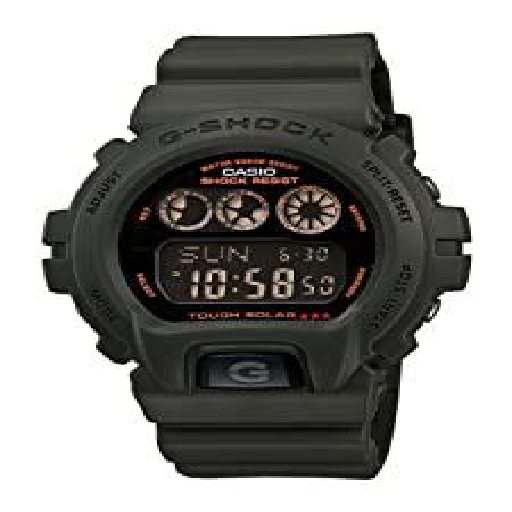

Product: 3
Product ID: B00BU6RUU6
Title: Casio Men's GD350-1B G Shock Black Watch
Brand: Casio
Price: $112.0
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B00BU6RUU6



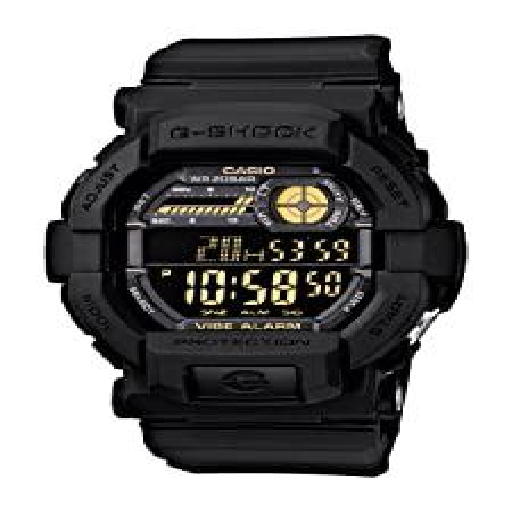

Product: 4
Product ID: B000AR7RZY
Title: Casio Men's W94HF-3AV Sport Watch
Brand: Casio
Price: $17.47
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B000AR7RZY



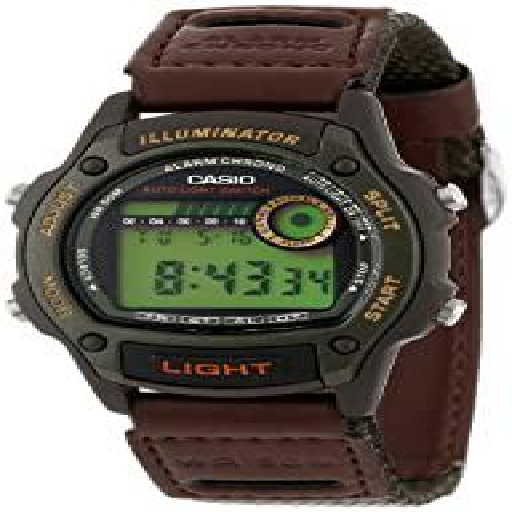

Product: 5
Product ID: B006WV32Z6
Title: Casio G-Shock Mens Watch G8900A-4D
Brand: Casio
Price: $93.0
Rating: 5.0 out of 5.0
Url: https://www.amazon.com/dp/B006WV32Z6



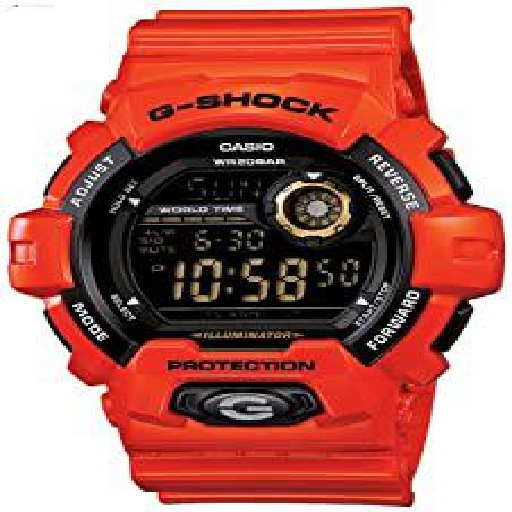

In [13]:
updater.start_polling()

---